# Geolocalización mean distance

Calculemos, en vez de accuracy, las métricas de mean y median distance

[Geolocation prediction in social media data by finding location indicative words](http://www.aclweb.org/anthology/C12-1064)

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd

dist_df = pd.read_csv("../data/geoloc/distancias.csv", index_col=0)

def prov_dist(p1, p2):
    return dist_df[p1][p2]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

df_train = pd.read_json("data/geoloc/users_train.json")
df_test = pd.read_json("data/geoloc/users_test.json")

Hagamos lo siguiente:

- Entrenemos con unigramas una regresión logística para 
- Luego probemos con los regionalismos

Primero, partamos en train, test

## Palabras precalculadas

Carguemos antes las palabras que sabemos que ocurren una cantidad razonable de veces

In [5]:
%%time
from contrastes.processing import build_dataframe_from_users

word_df = build_dataframe_from_users(row for index, row in df_train.iterrows())

CPU times: user 8min 33s, sys: 712 ms, total: 8min 34s
Wall time: 8min 34s


In [6]:
from contrastes.processing import preprocess_raw_df

word_df = preprocess_raw_df(word_df, filter_words=(10, 2))

/home/jmperez/projects/contrastes/notebooks/contrastes/processing.py:185: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_palabras = cant_palabras
/home/jmperez/projects/contrastes/notebooks/contrastes/processing.py:186: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_personas = cant_personas


In [7]:
from contrastes.lists import add_ival

add_ival(word_df, normalize=True)

Calculating information values...
Calculating ranks...


In [9]:
word_df.sort_values("rank_personas", ascending=True, inplace=True)


In [10]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords


tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
liw_vectorizer = CountVectorizer(
    tokenizer=tokenizer.tokenize,
    vocabulary=word_df.index[:10000])

X_train = liw_vectorizer.fit_transform(df_train["text"])
print("Vectorizing")
X_test = liw_vectorizer.transform(df_test["text"])

Vectorizing
CPU times: user 10min 23s, sys: 68 ms, total: 10min 23s
Wall time: 10min 23s


In [13]:
print("Vocabulario del vectorizador: {} palabras".format(len(liw_vectorizer.vocabulary_)))

Vocabulario del vectorizador: 10000 palabras


In [14]:
from sklearn.preprocessing import LabelEncoder

province_encoder = LabelEncoder()

province_encoder.fit(df_train["provincia"].values)

LabelEncoder()

In [15]:
y_train = province_encoder.transform(df_train["provincia"].values)
y_test = province_encoder.transform(df_test["provincia"].values)

La reg. logística será un softmax, así que elijo `multi_class='multinomial'`

In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class='multinomial', solver='saga', penalty='l2',
    max_iter=200, n_jobs=-1
)

clf.fit(X_train, y_train)

/home/jmperez/.pyenv/versions/3.6.5/envs/contrastes/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

Ahora, calculemos las provincias predecidas 

In [20]:
real_prov = province_encoder.inverse_transform(y_test)
pred_prov = province_encoder.inverse_transform(clf.predict(X_test))

In [38]:
clf.score(X_test, y_test)

0.7356

In [27]:
import numpy as np

distances = np.array([prov_dist(p1, p2) for p1, p2 in zip(real_prov, pred_prov)])

distances.mean(), np.median(distances)

(205.6376, 0.0)

In [39]:
for idx in np.nonzero(distances)[0]:
    print("Real {:<15} predijo {:<15} (distancia {})".format(
        real_prov[idx], pred_prov[idx], distances[idx])
    )

Real santafe         predijo buenosaires     (distancia 393)
Real mendoza         predijo catamarca       (distancia 569)
Real catamarca       predijo larioja         (distancia 149)
Real sanjuan         predijo santafe         (distancia 740)
Real chubut          predijo tucuman         (distancia 1827)
Real tucuman         predijo chaco           (distancia 620)
Real sanluis         predijo sanjuan         (distancia 284)
Real neuquen         predijo chaco           (distancia 1529)
Real corrientes      predijo misiones        (distancia 291)
Real sanjuan         predijo larioja         (distancia 283)
Real corrientes      predijo chaco           (distancia 13)
Real santacruz       predijo tierradelfuego  (distancia 359)
Real sanjuan         predijo santafe         (distancia 740)
Real santafe         predijo chaco           (distancia 495)
Real santafe         predijo formosa         (distancia 654)
Real salta           predijo corrientes      (distancia 719)
Real sanjuan         pr

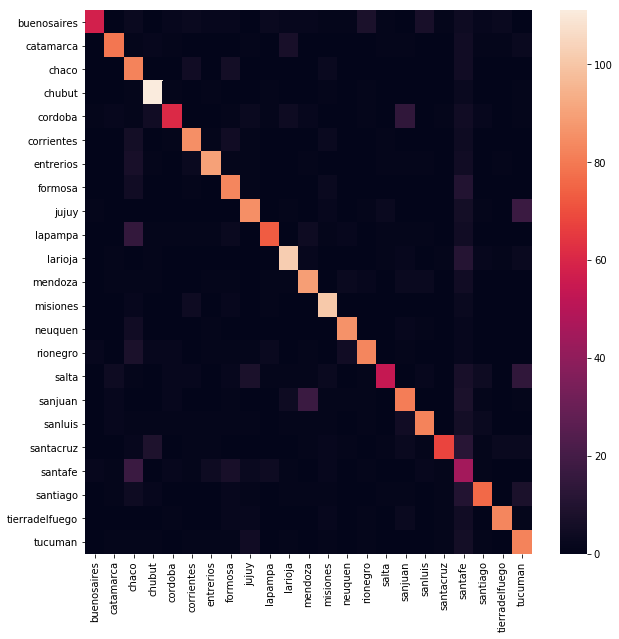

In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
cm = confusion_matrix(real_prov, pred_prov)


df_cm = pd.DataFrame(cm, index=province_encoder.classes_, columns=province_encoder.classes_)

sns.heatmap(df_cm)

2500 palabras dan un accuracy de 71%. BASTANTE BIEN. Luego disminuye la performance